## **Semantic Segmentation using Traditional CV Techniques: Thresholding and Edge Detection**
Applied to the Oxford-IIIT Pet Dataset

By

***Lt Col Ritesh Lamba***

***M23CSA544***

## ***Download and extract Oxford-IIIT Pet dataset (images + trimaps)***

In [2]:
# Download and extract Oxford-IIIT Pet dataset (images + trimaps)
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!mkdir -p oxford_pets
!tar -xzf images.tar.gz -C oxford_pets/
!tar -xzf annotations.tar.gz -C oxford_pets/

--2025-04-06 07:22:23--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-04-06 07:22:24--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  32.3MB/s    in 24s     

2025-04-06 07:22:49 (31.3 MB/s) - ‘images.tar.gz.1’ saved [791918971/791918971]

--2025-04-06 07:22:49--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving w

Import Dependencies

In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import closing, footprint_rectangle, square
from glob import glob
import random
from sklearn.metrics import jaccard_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Load Image and Convert to Grayscale

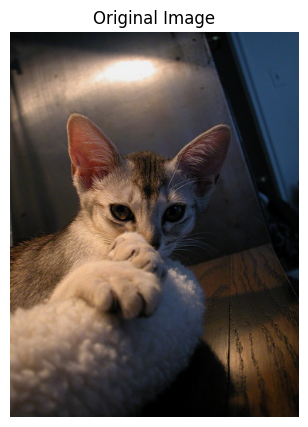

In [37]:
# Set image path (use your own path here)
image_dir = 'oxford_pets/images/'
image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))

# Check if image exists
if not image_paths:
    raise FileNotFoundError("No images found in the 'oxford_pets/images/' directory. Please download Oxford-IIIT Pet dataset.")

# Load the first image for demonstration
img_path = image_paths[0]
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Show original image
plt.figure(figsize=(5, 5))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 2. Otsu's Thresholding

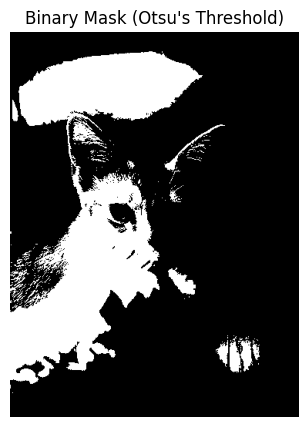

In [38]:
# Apply thresholding
thresh_val = threshold_otsu(gray)
binary_mask = gray > thresh_val
binary_uint8 = (binary_mask * 255).astype(np.uint8)

# Show binary mask
plt.figure(figsize=(5, 5))
plt.title("Binary Mask (Otsu's Threshold)")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()

### 3. Canny Edge Detection

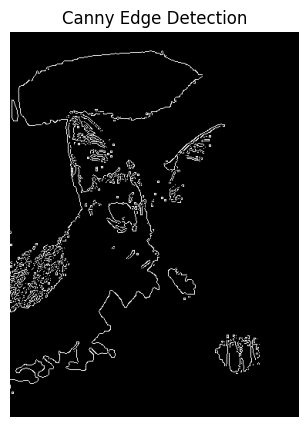

In [39]:
edges = cv2.Canny(binary_uint8, 100, 200)

plt.figure(figsize=(5, 5))
plt.title("Canny Edge Detection")
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

### 4. Morphological Closing to Refine Edges

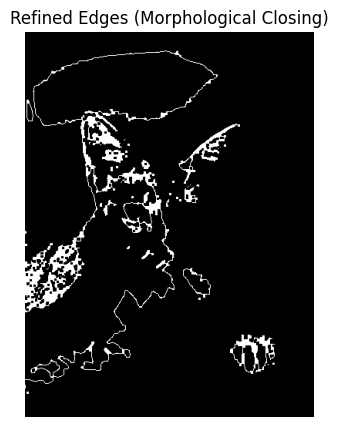

In [40]:
refined = closing(edges > 0, square(3))

plt.figure(figsize=(5, 5))
plt.title("Refined Edges (Morphological Closing)")
plt.imshow(refined, cmap='gray')
plt.axis('off')
plt.show()

### 5. Combined Visualization

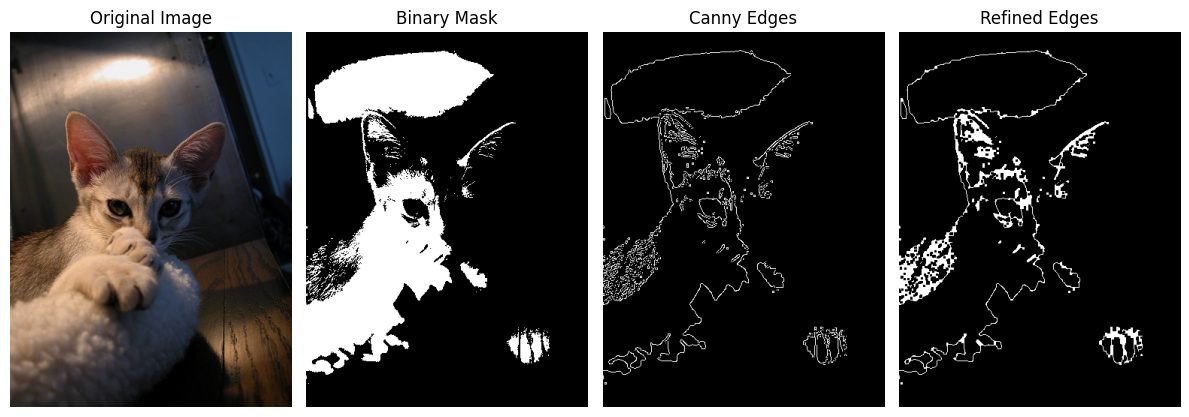

In [41]:
titles = ['Original Image', 'Binary Mask', 'Canny Edges', 'Refined Edges']
images = [image, binary_mask, edges, refined]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    if i == 0:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 6. Load 10 Random Images and Calculate the IOU Score from this Approach

In [42]:
# Define dataset paths (adjust if you've stored them somewhere else)
image_dir = 'oxford_pets/images/'
mask_dir = 'oxford_pets/annotations/trimaps/'

# Load all image and mask file paths
image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

print(f"Loaded {len(image_paths)} images and {len(mask_paths)} masks.")

Loaded 470 images and 7390 masks.


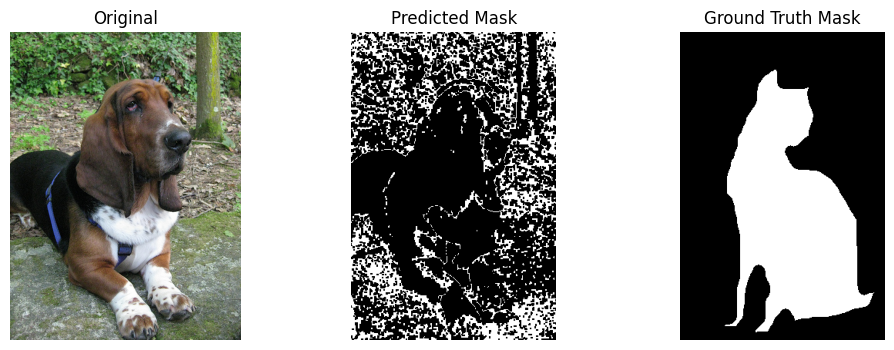


IoU Scores for 10 Samples:
Image 1: IoU = 0.0782
Image 2: IoU = 0.0793
Image 3: IoU = 0.0278
Image 4: IoU = 0.0401
Image 5: IoU = 0.0291
Image 6: IoU = 0.0618
Image 7: IoU = 0.1238
Image 8: IoU = 0.0681
Image 9: IoU = 0.0676
Image 10: IoU = 0.0445


In [43]:
# Pick 10 random samples
sample_indices = random.sample(range(len(image_paths)), 10)
selected_images = [image_paths[i] for i in sample_indices]
selected_masks = [mask_paths[i] for i in sample_indices]

ious = []

for i, (img_path, mask_path) in enumerate(zip(selected_images, selected_masks)):
    # Load and preprocess image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Otsu thresholding
    thresh = threshold_otsu(gray)
    binary_mask = gray > thresh
    binary_uint8 = (binary_mask * 255).astype(np.uint8)

    # Edge detection and morphological closing
    edges = cv2.Canny(binary_uint8, 100, 200)
    refined = closing(edges > 0, square(3))

    # Load ground truth mask (label 1 = pet)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    gt_binary = (gt_mask == 1).astype(np.uint8)

    # Resize prediction to match ground truth
    refined_resized = cv2.resize(refined.astype(np.uint8), (gt_binary.shape[1], gt_binary.shape[0]))

    # Calculate IoU
    iou = jaccard_score(gt_binary.flatten(), refined_resized.flatten())
    ious.append(iou)

    # Visualize only first sample
    if i == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        plt.imshow(refined_resized, cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_binary, cmap='gray')
        plt.axis('off')
        plt.show()

# Print results
print("\nIoU Scores for 10 Samples:")
for idx, score in enumerate(ious):
    print(f"Image {idx+1}: IoU = {score:.4f}")

### 6. Save Results

In [44]:
output_dir = 'output/'
os.makedirs(output_dir, exist_ok=True)

cv2.imwrite(os.path.join(output_dir, 'otsu_mask.png'), binary_uint8)
cv2.imwrite(os.path.join(output_dir, 'canny_edges.png'), edges)
cv2.imwrite(os.path.join(output_dir, 'refined_edges.png'), (refined * 255).astype(np.uint8))

print("✅ Output images saved to 'output/' directory.")


✅ Output images saved to 'output/' directory.
